# Reparameterization layers

> In this post, we will cover how to use DenseReparameterization layer. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/HAR.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### Convolutional Neural network with reparameterization layer.

```python
model = Sequential([
    tfpl.Convolutional2DReparameterization(16, [3, 3], activation='relu', input_shape=(28, 28, 1)),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])
```

### Default Argument

```python
model = Sequential([
    tfpl.Convolutional2DReparameterization(16, [3, 3], activation='relu', input_shape=(28, 28, 1),
                                            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(), # Independent Normal Distribution
                                            kernel_prior_fn=tfpl.default_multivariate_normal_fn), # Spherical Gaussian
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])
```

For kernel_prior function, we can manually define it like this,

```python
def custom_multivariate_normal_fn(dtype, shape, name, trainable, add_variable_fn):
    normal = tfd.Normal(loc=tf.zeros(shape, dtype), scale=2 * tf.ones(shape, dtype))
    batch_ndims = tf.size(normal.batch_shape_tensor())
    return tfd.Independent(normal, reinterpreted_batch_ndims=batch_ndims)

model = Sequential([
    tfpl.Convolutional2DReparameterization(16, [3, 3], activation='relu', input_shape=(28, 28, 1),
                                            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(), # Independent Normal Distribution
                                            kernel_prior_fn=custom_multivariate_normal_fn), # Spherical Gaussian
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])
```

### Using bias argument

```python
model = Sequential([
    tfpl.Convolutional2DReparameterization(16, [3, 3], activation='relu', input_shape=(28, 28, 1),
                                            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(), # Independent Normal Distribution
                                            kernel_prior_fn=tfpl.default_multivariate_normal_fn, # Spherical Gaussian
                                            bias_posterior_fn=tfpl.default.mean_field_normal_fn(is_singular=True), # Point estimate
                                            bias_prior_fn=None),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])
```

### Smapling from the model

```python
model = Sequential([
    tfpl.Convolutional2DReparameterization(16, [3, 3], activation='relu', input_shape=(28, 28, 1),
                                            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(), # Independent Normal Distribution
                                            kernel_posterior_tensor_fn=tfd.Distribution.sample,
                                            kernel_prior_fn=tfpl.default_multivariate_normal_fn, # Spherical Gaussian
                                            bias_posterior_fn=tfpl.default.mean_field_normal_fn(is_singular=True), # Point estimate
                                            bias_posterior_tensor_fn=tfd.Distribution.sample,
                                            bias_prior_fn=None,
                                           kernel_divergence_fn=(lambda q, p, _: tfd.kl_divergence(q, p))), # Analytic solution
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])
```

## Tutorial

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os

### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

> Note: Due to the size of dataset, I removed x_train.npy.

In [11]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = './dataset/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(X_train, y_train), (X_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

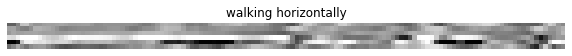

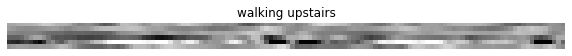

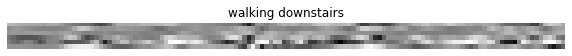

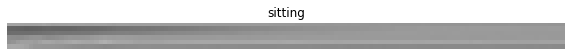

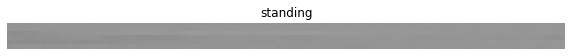

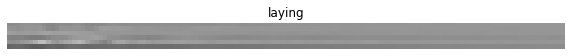

In [13]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = X_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

### 1D deterministic convolutional neural network

In [7]:
# Create standard deterministic model with
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


### Probabilistic 1D Convolutional neural network, with both weight and output uncertainty

In [16]:
# Create probabilistic model with the following layers:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense
# - OneHotCategorical

divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(
        input_shape=(128, 6), filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    ),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    ),
    tfpl.OneHotCategorical(6)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_1  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization (De (None, 6)                 684       
_________________________________________________________________
one_hot_categorical (OneHotC multiple                  0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
# Replace analytical Kullback-Leibler divergence with approximated one
# With Monte Carlo Approximation
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor: kl_approx(q, p, q_tensor) / X_train.shape[0]

In [18]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005), metrics=['accuracy'])

In [19]:
# Train the model
model.fit(X_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(X_train, y_train_oh)
model.evaluate(X_test, y_test_oh)

93/93 [==============================] - 0s 2ms/step - loss: 1.0375 - accuracy: 0.7068


[1.0374581813812256, 0.7068204879760742]

### Inspect model performance

In [20]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(X_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(X_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


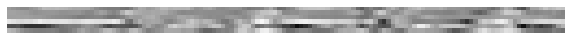

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


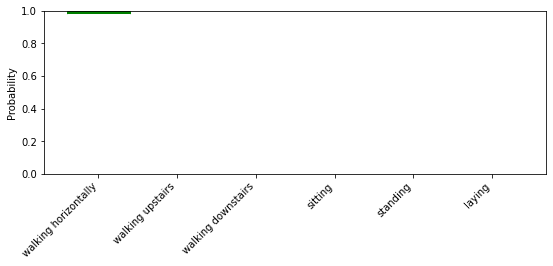

In [21]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


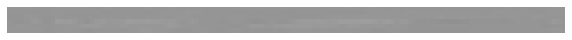

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


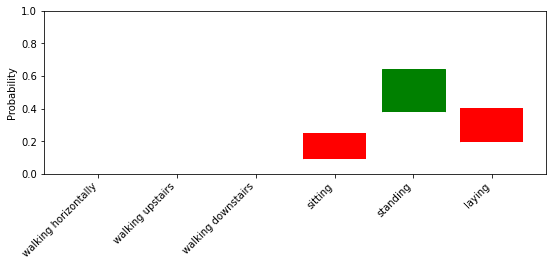

In [22]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


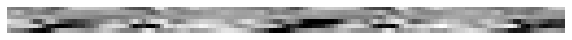

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


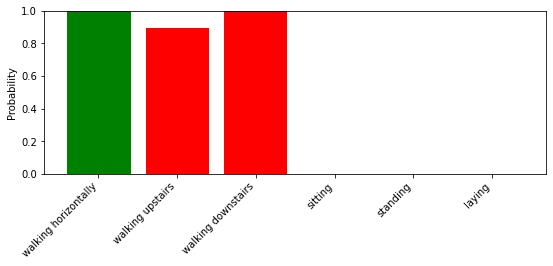

In [23]:
analyse_model_predictions(image_num=1137)